# Hodgekin-Huxley Neuron Model
Author: Christian Pehle

The Hodgekin-Huxley Neuron model is a foundational example of how to model non-linear and voltage dependent conductance changes in biological neuron models. The key idea is to model the fraction of open-to-closed ion-channels of a particular kind by fitting the voltage dependence of the channel state dynamics to the observed dynamics. Here we show how to implement this model using the primitives provided by the library for numerical integration and composition of dynamical systems.


In [1]:
import jax
import jax.numpy as np
import tree_math
import matplotlib.pyplot as plt
from njx.base import funcutils
from njx.base.types import ArrayLike

The dynamics for a collection of ion-channel is given by 
$$\dot{x} =  \alpha(v) (1 - x) - \beta(v) x,$$ 
where $\alpha$ and $\beta$ model experimentally determined voltage dependend switches, both map $\mathbf{R} \to [0,1]$ mononically, with opposite signs in their derivative.

In [2]:
def channel_dynamics(alpha, beta):
    def dynamics(x: ArrayLike, v: ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x

    return dynamics

Here we use a specific choice for the shape of these functions $\alpha, \beta$. One major challenge is that constants largely determine the "suitability" to model the specific dynamics of a particular class of ion-channles, with little systematic curation. Fits from experimental data in addition need to be referenced to the temperature at which they were taken. 

In [3]:
@tree_math.struct
class ChannelParameter:
    a : ArrayLike
    v_half : ArrayLike
    k : ArrayLike

def alpha(v, p: ChannelParameter):
    return p.a * (v - p.v_half) / (1 - np.exp((p.v_half - v) / p.k))

def beta(v, p: ChannelParameter):
    return -p.a * (v - p.v_half) / (1 - np.exp((p.v_half - v) / p.k))


def alpha_n(Vm):
    return (0.02 * (Vm - 25.0)) / (1.0 - np.exp((-1.0 * (Vm - 25.0)) / 9.0))


def beta_n(Vm):
    return (-0.002 * (Vm - 25.0)) / (1.0 - np.exp((Vm - 25.0) / 9.0))


def alpha_m(Vm):
    return (0.182 * (Vm + 35.0)) / (1.0 - np.exp((-1.0 * (Vm + 35.0)) / 9.0))


def beta_m(Vm):
    return (-0.124 * (Vm + 35.0)) / (1.0 - np.exp((Vm + 35.0) / 9.0))


def alpha_h(Vm):
    return 0.25 * np.exp((-1.0 * (Vm + 90.0)) / 12.0)


def beta_h(Vm):
    return (0.25 * np.exp((Vm + 62.0) / 6.0)) / np.exp((Vm + 90.0) / 12.0)

Given these choices we can visualise the equilibrium of these channel dynamics as

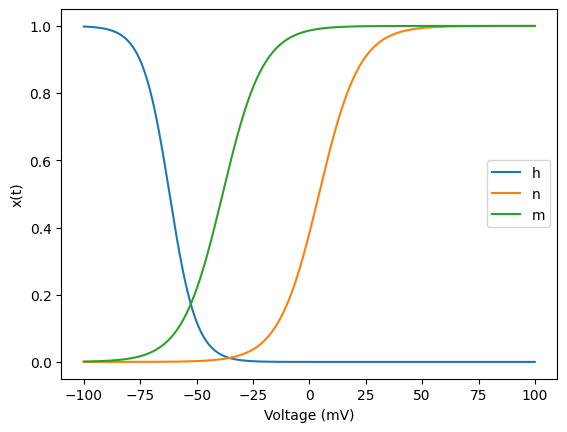

In [4]:
def x0(alpha, beta):
    def x0(v):
        return alpha(v) / (alpha(v) + beta(v))

    return x0


h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

vs = np.arange(-100, 100, 0.1)

fig, ax = plt.subplots(1)
ax.plot(vs, h0(vs), label="h")
ax.plot(vs, n0(vs), label="n")
ax.plot(vs, m0(vs), label="m")
ax.set_xlabel("Voltage (mV)")
ax.set_ylabel("x(t)")
ax.legend()

We can then model the state of a collection of (un-coupled) Hodgekin-Huxley neuron circuits as

In [5]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike


@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike

The overall dynamics is then given by currents for two different channels (Natrium and Kalium) that are modelled as

$$
\begin{aligned}
I_\mathrm{Na} &= g_\mathrm{Na} m^3 h (v - E_\mathrm{Na}) \\
I_\mathrm{K} &= g_\mathrm{K} n^4 (v - E_\mathrm{K}) \\
I_L &= g_L (v - E_\mathrm{L}) \\
C_m \dot{v} &= -(I_K(s,p) + I_Na(s, p) + I_L(s, p) - I)
\end{aligned}
$$

Using the abstractions we've introduced so far, this can be translated to JAX code almost as is:

In [6]:
def I_Na(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_Na * np.power(s.m, 3) * s.h * (s.v - p.E_Na)


def I_K(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * np.power(s.n, 4) * (s.v - p.E_K)


def I_L(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)


def hodgekin_huxley_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyState, I: ArrayLike):
        return HodgekinHuxleyState(
            v=-p.C_m_inv * (I_K(s, p) + I_Na(s, p) + I_L(s, p) - I),
            m=m_dynamics(s.m, s.v),
            n=n_dynamics(s.n, s.v),
            h=h_dynamics(s.h, s.v),
        )

    return dynamics

In [7]:
p = HodgekinHuxleyParameters(
    C_m_inv=1.0,  # Inverse Membrane capacitance per unit area (cm^2/uF)
    g_K=35.0,  # Average potassium channel conductance per unit area (mS/cm^2)
    g_Na=40.0,  # Average sodoum channel conductance per unit area (mS/cm^2)
    g_L=0.3,  # Average leak channel conductance per unit area (mS/cm^2)
    E_K=-77.0,  # Potassium potential (mV)
    E_Na=55.0,  # Sodium potential (mV)
    E_L=-65.0,  # Leak potential (mV)
)

In [8]:
from njx.base import explicit


def projection(x, u):
    return x


def output(x, u):
    return x


dynamics = hodgekin_huxley_dynamics(p)
equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=dynamics, projection=projection, output=output
)

ModuleNotFoundError: No module named 'jaxsnn'

We initialise the system in an equilibrium configuration for  $v, m, n, h$:

In [9]:
import numpy as onp

initial_state = HodgekinHuxleyState(v=p.E_L, m=m0(p.E_L), n=n0(p.E_L), h=h0(p.E_L))

T = 30000
dt = 0.01
step_fn = explicit.classic_rk4_cde(equation, dt)

stim = onp.zeros(T)
stim[7000:14000] = 2.7  # add a square pulse

integrator = funcutils.controlled_trajectory(step_fn, stim)
integrator = jax.jit(integrator)

In [10]:
%time integrator(initial_state)[1].v.block_until_ready()  # measure JAX compilation time
%timeit integrator(initial_state)[1].v.block_until_ready()  # measure JAX runtime

CPU times: user 198 ms, sys: 5.27 ms, total: 204 ms
Wall time: 201 ms
5.84 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
def integrate_from(initial_state, stim):
    integrator = funcutils.controlled_trajectory(step_fn, stim)
    _, actual = integrator(initial_state)
    return actual


integrate_from = jax.jit(integrate_from)
actual = integrate_from(initial_state=initial_state, stim=stim)

In [12]:
def plot_hodgekin_huxley(s: HodgekinHuxleyState, stimulus: ArrayLike):
    fig, ax = plt.subplots(3, figsize=(10, 5), sharex=True)
    ts = np.arange(0, int(dt * T), dt)
    ax[0].set_ylabel("Voltage (mV)")
    ax[1].set_ylabel("Current ($\mu A$)")
    ax[2].set_ylabel("x(t)")
    ax[0].plot(ts, s.v)
    ax[1].plot(ts, stimulus)
    ax[1].set_ybound(0, 5.5)
    ax[2].plot(ts, s.m, label="m")
    ax[2].plot(ts, s.h, label="h")
    ax[2].plot(ts, s.n, label="n")
    ax[2].legend(loc="upper right", frameon=False)
    # ax[3].plot(ts, s.m**3 * s.h, label="m")
    # ax[4].plot(ts, s.n**4, label="h")

    ax[2].set_xlabel("Time (ms)")

    # these constants are extracted from the specific
    ax[0].hlines(-35, ts[0], ts[-1], color="grey", linestyles="-.")
    ax[0].hlines(25, ts[0], ts[-1], color="grey", linestyles="-.")
    ax[0].hlines(-62, ts[0], ts[-1], color="grey", linestyles="-.")

    return fig, ax

This leads to the characteristic behaviour of the Hodgekin Huxley neuron model under a current pulse.

In [13]:
from ipywidgets import interact, IntSlider, FloatSlider
from functools import partial

IntSlider = partial(IntSlider, continuous_update=False)
FloatSlider = partial(FloatSlider, continuous_update=True)


@interact(
    I_stim=FloatSlider(min=0.0, max=100.0, step=0.1, value=2.7),
    t_stim=IntSlider(min=100, max=14000, step=1, value=7000),
)
def experiment(I_stim, t_stim):
    stim = onp.zeros(T)
    stim[7000 : 7000 + t_stim] = I_stim  # add a square pulse
    initial_state = HodgekinHuxleyState(v=p.E_L, m=m0(p.E_L), n=n0(p.E_L), h=h0(p.E_L))
    actual = integrate_from(initial_state=initial_state, stim=stim)
    plot_hodgekin_huxley(actual, stimulus=stim)

interactive(children=(FloatSlider(value=2.7, description='I_stim'), IntSlider(value=7000, continuous_update=Fa…

## References 